In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
from torch import nn

import ml.losses as mll
import ml.models as mlm
import ml.models_cv as mlcv

#### classification dataset

In [118]:
X, y = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_classes=1, n_redundant=0, n_clusters_per_class=3, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

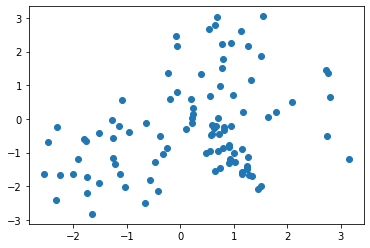

In [119]:
plt.scatter(X[:, 0], X[:, 1])

#### regression dataset

In [85]:
X, y, coef = datasets.make_regression(n_samples=2000, n_features=20, n_targets=5, bias=0.5, coef=True, n_informative=3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear regression 

In [99]:
n, m = X_train.shape
out_dim = 1 if y_train.ndim == 1 else y_train.shape[1]

model = mlm.LinearRegression(m, out_dim)

In [100]:
training_loss, train_acc, val_acc = model.fit(X_train, y_train, lr=0.01, n_iter=250, reg=0.3, n=interval, X_val=X_test, y_val=y_test)

iteration 0: training loss 9373.25  training accuracy 9082.04 val accuracy 9679.05
iteration 5: training loss 8964.39  training accuracy 8702.78 val accuracy 9286.89
iteration 10: training loss 8595.06  training accuracy 8350.23 val accuracy 8921.92
iteration 15: training loss 8261.45  training accuracy 8022.29 val accuracy 8582.05
iteration 20: training loss 7960.09  training accuracy 7717.03 val accuracy 8265.36
iteration 25: training loss 7687.86  training accuracy 7432.72 val accuracy 7970.07
iteration 30: training loss 7441.93  training accuracy 7167.75 val accuracy 7694.57
iteration 35: training loss 7219.77  training accuracy 6920.65 val accuracy 7437.38
iteration 40: training loss 7019.06  training accuracy 6690.06 val accuracy 7197.14
iteration 45: training loss 6837.73  training accuracy 6474.76 val accuracy 6972.60
iteration 50: training loss 6673.91  training accuracy 6273.62 val accuracy 6762.61
iteration 55: training loss 6525.90  training accuracy 6085.59 val accuracy 65

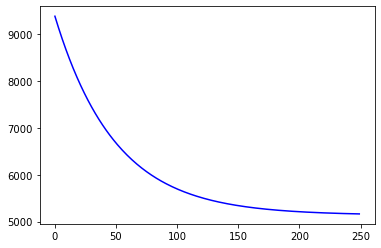

In [101]:
fig, ax = plt.subplots()
ax.plot(range(len(training_loss)), training_loss, 'blue')
# ax.plot(range(len(val_loss)), val_loss, 'orange')
plt.show()

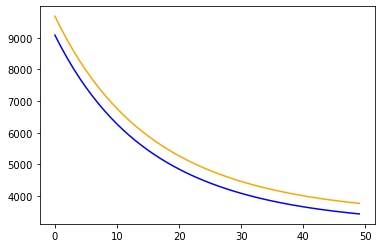

In [102]:
fig, ax = plt.subplots()
ax.plot(range(len(train_acc)), train_acc, 'blue')
ax.plot(range(len(val_acc)), val_acc, 'orange')
plt.show()

#### Logistic regression

In [255]:
n, m = X_train.shape
out_dim = 1 if y_train.ndim == 1 else y_train.shape[1]

In [277]:
model = mlm.LogisticRegression(m, out_dim)

In [278]:
training_loss, train_acc, val_acc = model.fit(X_train, y_train, lr=0.01, n_iter=3000, reg=0.01, n=50, X_val=X_test, y_val=y_test)

iteration 0: training loss 2.42  training acc 0.52 val acc 0.59
iteration 50: training loss 2.27  training acc 0.53 val acc 0.59
iteration 100: training loss 2.13  training acc 0.53 val acc 0.59
iteration 150: training loss 1.99  training acc 0.54 val acc 0.59
iteration 200: training loss 1.87  training acc 0.54 val acc 0.60
iteration 250: training loss 1.75  training acc 0.55 val acc 0.60
iteration 300: training loss 1.64  training acc 0.55 val acc 0.61
iteration 350: training loss 1.54  training acc 0.56 val acc 0.60
iteration 400: training loss 1.45  training acc 0.55 val acc 0.61
iteration 450: training loss 1.36  training acc 0.56 val acc 0.62
iteration 500: training loss 1.28  training acc 0.56 val acc 0.62
iteration 550: training loss 1.20  training acc 0.57 val acc 0.62
iteration 600: training loss 1.13  training acc 0.58 val acc 0.62
iteration 650: training loss 1.07  training acc 0.58 val acc 0.64
iteration 700: training loss 1.01  training acc 0.59 val acc 0.64
iteration 750

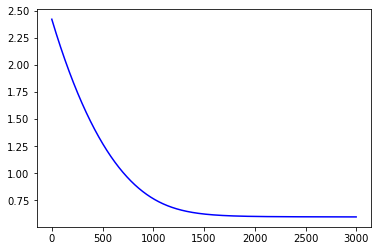

In [279]:
fig, ax = plt.subplots()
ax.plot(range(len(training_loss)), training_loss, 'blue')
# ax.plot(range(len(val_loss)), val_loss, 'orange')
plt.show()

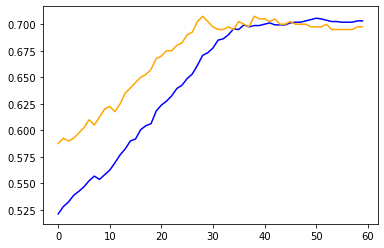

In [280]:
fig, ax = plt.subplots()
ax.plot(range(len(train_acc)), train_acc, 'blue')
ax.plot(range(len(val_acc)), val_acc, 'orange')
plt.show()

#### Logistic regression with Pytorch

In [226]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)
        
    def forward(self, x):
        output = torch.sigmoid(self.linear(x))
        return output

In [195]:
model = LogisticRegression(m, out_dim)

In [198]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_val, y_val = torch.Tensor(X_test), torch.Tensor(y_test)

In [229]:
def train_torch(X, y, X_val, y_val, n_iter=200, lr=0.01, reg=0, n=5):
    training_loss = []
    training_acc = []
    val_acc = []
    
    model = LogisticRegression(m, out_dim)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=reg)

    for i in range(n_iter):
        y_pred = model(X_train)
        loss = criterion(torch.squeeze(y_pred), y_train)
        training_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % n == 0:
            with torch.no_grad():
                y_pred_val = model(X_val).squeeze()
                t_acc = ((np.round(y_pred).squeeze() == y).float()).mean()
                v_acc = ((np.round(y_pred_val) == y_val).float()).mean()

                training_acc.append(t_acc)
                val_acc.append(v_acc)            
                print(f'iteration {i}: training loss {loss:.2f} ' +
                          f' training acc {t_acc:.2f} val acc {v_acc:.2f}')
                
    return training_loss, training_acc, val_acc

In [251]:
training_loss, training_acc, val_acc = train_torch(X_train, y_train, X_val, y_val, n_iter=800, lr=0.01, reg=0.001, n=10)

iteration 0: training loss 0.70  training acc 0.54 val acc 0.56
iteration 10: training loss 0.69  training acc 0.55 val acc 0.58
iteration 20: training loss 0.68  training acc 0.57 val acc 0.59
iteration 30: training loss 0.67  training acc 0.58 val acc 0.59
iteration 40: training loss 0.66  training acc 0.60 val acc 0.61
iteration 50: training loss 0.66  training acc 0.62 val acc 0.62
iteration 60: training loss 0.65  training acc 0.62 val acc 0.63
iteration 70: training loss 0.65  training acc 0.63 val acc 0.64
iteration 80: training loss 0.64  training acc 0.64 val acc 0.64
iteration 90: training loss 0.64  training acc 0.64 val acc 0.65
iteration 100: training loss 0.64  training acc 0.64 val acc 0.66
iteration 110: training loss 0.64  training acc 0.65 val acc 0.67
iteration 120: training loss 0.63  training acc 0.65 val acc 0.68
iteration 130: training loss 0.63  training acc 0.65 val acc 0.68
iteration 140: training loss 0.63  training acc 0.65 val acc 0.68
iteration 150: traini

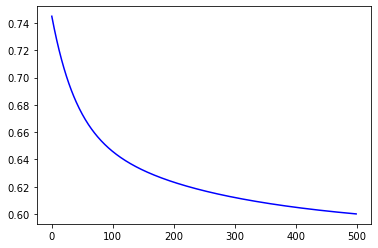

In [249]:
fig, ax = plt.subplots()
ax.plot(range(len(training_loss)), training_loss, 'blue')
# ax.plot(range(len(val_loss)), val_loss, 'orange')
plt.show()

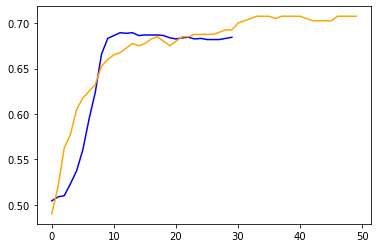

In [250]:
fig, ax = plt.subplots()
ax.plot(range(len(train_acc)), train_acc, 'blue')
ax.plot(range(len(val_acc)), val_acc, 'orange')
plt.show()

In [200]:
loss

tensor(0.7554, grad_fn=<BinaryCrossEntropyBackward0>)

In [29]:
model.linear.weight.grad

tensor([[ 0.2200, -0.0869,  0.2586, -0.0407,  0.0485,  0.0630, -0.4709, -0.0581,
         -0.0335,  0.0434]])

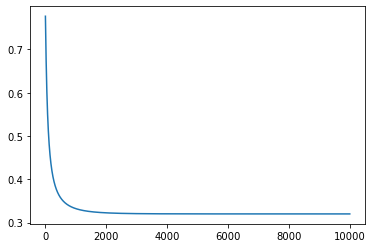

In [20]:
plt.plot(range(len(training_loss)), training_loss)

#### Softmax classification

In [34]:
n_sample, n_feature = X_train.shape
out_dim = 5

In [45]:
model = mlm.TwoLayerNet(n_feature, 10, out_dim)

In [46]:
training_loss, val_loss = model.fit(X_train, y_train, 0.01, 1000, reg=0, n=50, x_val=X_test, y_val=y_test)

Interation i: training loss 12.03, validation loss 12.19
Interation i: training loss 7.67, validation loss 7.75
Interation i: training loss 5.38, validation loss 5.42
Interation i: training loss 3.99, validation loss 4.01
Interation i: training loss 3.10, validation loss 3.14
Interation i: training loss 2.53, validation loss 2.59
Interation i: training loss 2.17, validation loss 2.23
Interation i: training loss 1.95, validation loss 2.01
Interation i: training loss 1.80, validation loss 1.85
Interation i: training loss 1.68, validation loss 1.73
Interation i: training loss 1.60, validation loss 1.64
Interation i: training loss 1.53, validation loss 1.57
Interation i: training loss 1.48, validation loss 1.52
Interation i: training loss 1.43, validation loss 1.47
Interation i: training loss 1.40, validation loss 1.43
Interation i: training loss 1.37, validation loss 1.40
Interation i: training loss 1.34, validation loss 1.38
Interation i: training loss 1.32, validation loss 1.35
Interati

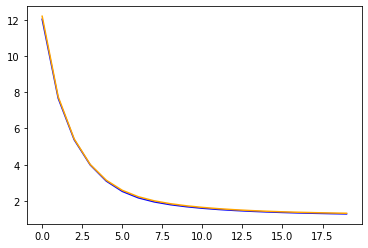

In [47]:
fig, ax = plt.subplots()
ax.plot(range(len(training_loss)), training_loss, 'blue')
ax.plot(range(len(val_loss)), val_loss, 'orange')
plt.show()

#### SVM classifier

In [23]:
def svm_loss(x, y):
    N = x.shape[0]
    correct_class_scores = x[torch.arange(N), y]
    margins = (x - correct_class_scores[:, None] + 1.0).clamp(min=0.)
    margins[torch.arange(N), y] = 0.
    loss = margins.sum() / N
    num_pos = (margins > 0).sum(dim=1)
    dx = torch.zeros_like(x)
    dx[margins > 0] = 1.
    dx[torch.arange(N), y] -= num_pos.to(dx.dtype)
    dx /= N

    return loss, dx

In [10]:
n, in_features = X_train.shape
n_classes = 5

In [4]:
svmloss = mll.SVMLoss()

In [11]:
y_pred = np.random.randn(n, n_classes)

In [13]:
y_pred.shape

(1600, 5)

In [35]:
svmloss(y_train, y_pred)

4.7887346357284

In [28]:
y_t = torch.tensor(y_train)
y_p_t = torch.tensor(y_pred)

In [37]:
l, dx = svm_loss(y_p_t, y_t)

#### Batch Normalization

In [59]:
def print_mean_std(x, dim=0):
  means = ['%.3f' % xx for xx in x.mean(axis=dim).tolist()]
  stds = ['%.3f' % xx for xx in x.std(axis=dim).tolist()]
  print('  means: ', means)
  print('  stds:  ', stds)
  print()

# Simulate the forward pass for a two-layer network
np.random.seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.clip(X @ W1, 0, None) @ W2

print('Before batch normalization:')
print_mean_std(a, dim=0)

# Run with gamma=1, beta=0. Means should be close to zero and stds close to one
bn = mlm.BatchNorm(D3)
print('After batch normalization (gamma=1, beta=0)')
a_norm = bn.forward(a)
print_mean_std(a_norm, dim=0)

# # Run again with nontrivial gamma and beta. Now means should be close to beta
# # and std should be close to gamma.
gamma = np.array([1.0, 2.0, 3.0])
beta = np.array([11.0, 12.0, 13.0])
print('After batch normalization (gamma=', bn.gamma.tolist(), ', beta=', bn.beta.tolist(), ')')
a_norm = bn.forward(a, gamma, beta)
print_mean_std(a_norm, dim=0)

Before batch normalization:
  means:  ['20.870', '-10.082', '30.400']
  stds:   ['31.209', '31.576', '40.825']

After batch normalization (gamma=1, beta=0)
  means:  ['-0.000', '0.000', '0.000']
  stds:   ['1.000', '1.000', '1.000']

After batch normalization (gamma= [1.0, 1.0, 1.0] , beta= [0.0, 0.0, 0.0] )
  means:  ['11.000', '12.000', '13.000']
  stds:   ['1.000', '2.000', '3.000']



In [60]:
np.random.seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn = mlm.BatchNorm(D3)

for t in range(500):
    X = np.random.randn(N, D1)
    a = np.clip(X @ W1, 0, None) @ W2
    bn.forward(a)

X = np.random.randn(N, D1)
a = np.clip(X @ W1, 0, None) @ W2
a_norm = bn.forward(a, mode='test')

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm, dim=0)

After batch normalization (test-time):
  means:  ['-0.037', '0.008', '0.106']
  stds:   ['1.018', '1.071', '1.067']



#### KNN

In [149]:
def predict_label(similarity, y, k):
    from collections import Counter

    y_pred = []  ## size k, x size k
    indices = np.argpartition(similarity, k, axis=1)[:, :k]  ## k x n
    print(indices)

    for i in range(len(similarity)):
        print(indices[i], y[indices[i]])
        classes_count = Counter(y[indices[i]])
        print(classes_count)
        pred = classes_count.most_common()[0][0]
        print(pred)
        y_pred.append(pred)

    return y_pred

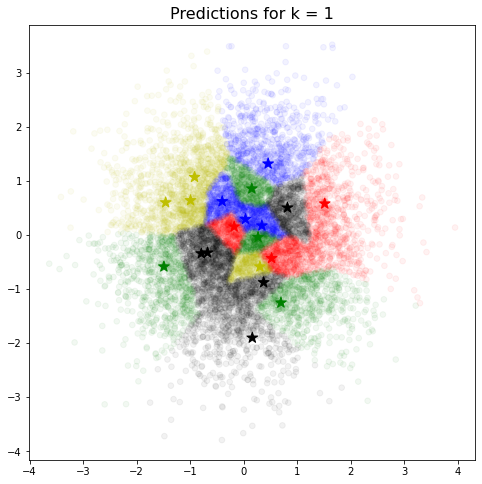

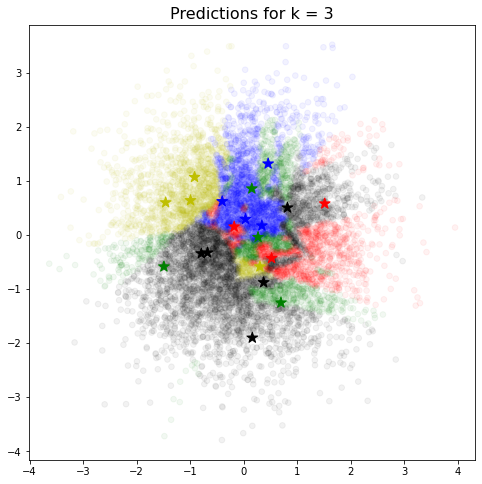

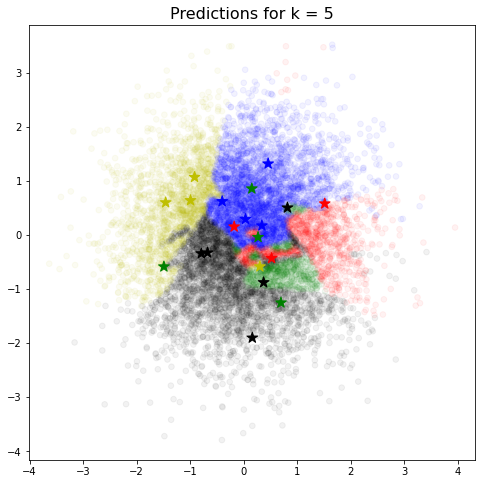

In [158]:
num_test = 10000
num_train = 20
num_classes = 5

# Generate random training and test data
np.random.seed(128)
x_train = np.random.randn(num_train, 2)
y_train = np.array([np.random.randint(num_classes) for _ in range(num_train)])
x_test = np.random.randn(num_test, 2)
classifier = mlm.KNN(x_train, y_train)

# Plot predictions for different values of k
for k in [1, 3, 5]:
    y_test = classifier.predict(x_test, k=k)
    plt.gcf().set_size_inches(8, 8)
    class_colors = ['r', 'g', 'b', 'k', 'y']
    train_colors = [class_colors[c] for c in y_train]
    test_colors = [class_colors[c] for c in y_test]
    plt.scatter(x_test[:, 0], x_test[:, 1],
                color=test_colors, marker='o', s=32, alpha=0.05)
    plt.scatter(x_train[:, 0], x_train[:, 1],
                color=train_colors, marker='*', s=128.0)
    plt.title('Predictions for k = %d' % k, size=16)
    plt.show()

In [332]:
dataset = datasets.load_digits()

X, y = dataset.data, dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [333]:
knn = mlm.KNN(X_train, y_train)

In [335]:
y_pred = knn.predict(X_test, k=3)

In [336]:
knn.score(y_test, y_pred)

98.33333333333333

In [341]:
k_acc = knn.cross_validation(k_choices=[1, 3, 5, 7])

In [342]:
k_acc

{1: [98.95833333333334,
  98.26388888888889,
  98.25783972125436,
  99.30313588850174,
  98.25783972125436],
 3: [99.65277777777779,
  97.56944444444444,
  97.21254355400697,
  99.65156794425087,
  98.25783972125436],
 5: [99.65277777777779,
  97.91666666666666,
  97.5609756097561,
  98.60627177700349,
  97.90940766550523],
 7: [99.30555555555556,
  97.56944444444444,
  97.90940766550523,
  98.60627177700349,
  97.5609756097561]}

#### K Means

In [218]:
X, y = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_classes=1, n_redundant=0, n_clusters_per_class=3, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

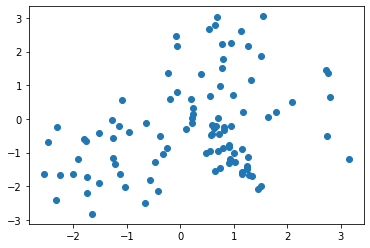

In [219]:
plt.scatter(X[:, 0], X[:, 1])

In [233]:
kmeans = mlm.KMeans(k=5)

In [234]:
kmeans.fit(X, max_iter=50)

interate 0
Done! Iterate 6 steps


In [243]:
kmeans.scores(X)

-75.06609737763598

In [346]:
scores = []
for i in [1, 3, 5, 7, 9]:
    kmeans = mlm.KMeans(k=i)
    kmeans.fit(X, max_iter=50)
    score = kmeans.score(X)
    print(f'iteration {i}: score {score}')
    scores.append(score)

Done! Iterate 1 steps
iteration 1: score -2159057.291040623
Done! Iterate 14 steps
iteration 3: score -1733027.4498210666
Done! Iterate 9 steps
iteration 5: score -1500815.3575918335
Done! Iterate 20 steps
iteration 7: score -1347629.2343075783
Done! Iterate 15 steps
iteration 9: score -1202326.9617268734


In [347]:
from sklearn.decomposition import PCA

In [348]:
pca = PCA(n_components=2).fit(X)

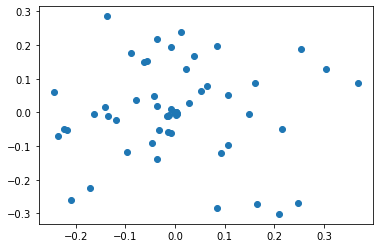

In [353]:
plt.scatter(pca.components_[0], pca.components_[1])

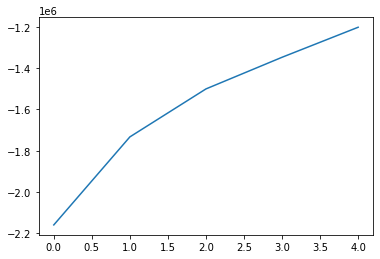

In [354]:
plt.plot(scores)

interate 0
Done! Iterate 1 steps
iteration 1: score -352.2349570978582


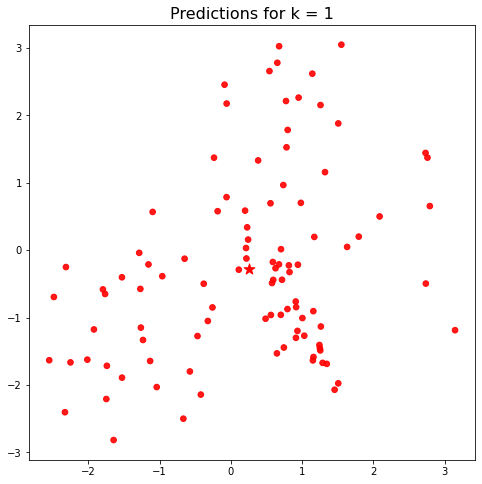

interate 0
Done! Iterate 3 steps
iteration 3: score -104.5610933609817


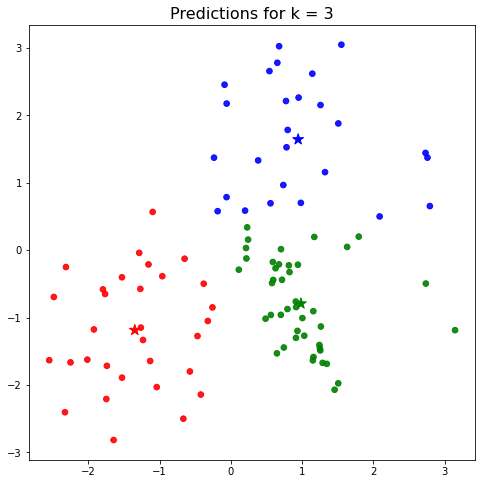

interate 0
Done! Iterate 6 steps
iteration 5: score -66.0443891264485


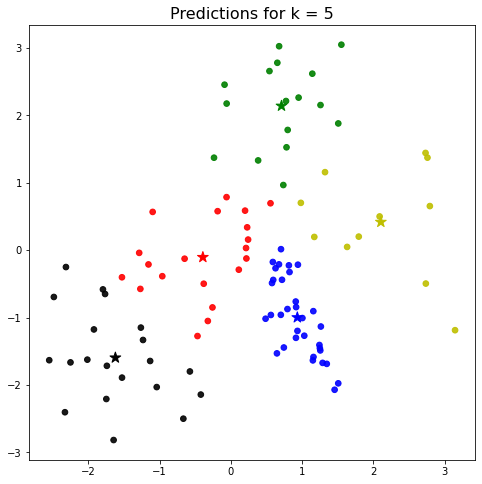

In [247]:
scores = []
for i in [1, 3, 5]:
    kmeans = mlm.KMeans(k=i)
    kmeans.fit(X, max_iter=50)
    score = kmeans.score(X)
    print(f'iteration {i}: score {score}')
    scores.append(score)
    class_colors = ['r', 'g', 'b', 'k', 'y']
    c_colors = [class_colors[c] for c in range(len(kmeans.centroids))]
    colors = [class_colors[c] for c in kmeans.clusters]
    plt.gcf().set_size_inches(8, 8)
    plt.scatter(X[:, 0], X[:, 1],
                color=colors, marker='o', s=32, alpha=0.9)
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
                color=c_colors, marker='*', s=128.0)
    plt.title('Predictions for k = %d' % kmeans.k, size=16)
    plt.show()

In [355]:
dataset = datasets.load_digits()

X, y = dataset.data, dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [356]:
kmeans = mlm.KMeans(k=9)

In [357]:
reduced_data = PCA(n_components=2).fit_transform(X)

In [359]:
h = 0.02
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Done! Iterate 15 steps


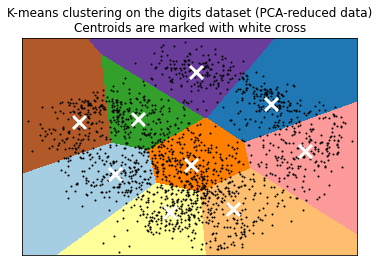

In [364]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = mlm.KMeans(k=9)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.centroids
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#### Binary classification metrics

In [285]:
import sklearn.metrics

In [308]:
metrics = mll.BinaryClassificationMetrices()

In [309]:
y = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1])
y_pred = np.array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0])

In [310]:
sklearn.metrics.f1_score(y, y_pred)

0.5454545454545454

In [311]:
metrics.confusion_matrics(y, y_pred)

[[3, 2], [3, 2]]

In [312]:
metrics.precision()

0.6

In [313]:
metrics.recall()

0.5

In [315]:
metrics.F1()

0.5454545454545454

#### Distance

In [365]:
A = np.array([[1,2,3],[2,3,4],[0,1,2]])
B = np.array([[1,2,3],[4,3,2]])

In [372]:
t1 = A[:, :, None]

In [373]:
t2 = B.T[None, :]

In [376]:
t = np.abs(t1 - t2)

In [379]:
t.sum(axis=1)

array([[0, 5],
       [3, 4],
       [3, 6]])

In [381]:
mlm.manhattan_distance(A, B[0])

array([[3, 2, 3],
       [6, 3, 2],
       [2, 3, 6]])

#### Decision Tree

In [382]:
dtree = mlm.DecisionTree()